In [27]:
%matplotlib inline

import os
import numpy as np
from analysis.models.vr import RatCAVESession
from analysis.models.spiking import units_per_session, unit_data
from analysis.plots.placecells import double_place_field_plot, unit_place_firing_with_autocorr

# VShiftA -------------

# 002430
sessions = ["2019-02-26_19-54-47"]  # interesting (demo of arena move)

# 002431
sessions = ["2019-02-26_20-09-44"]

# 00908
sessions = [
    "2019-07-08_17-46-20",
    "2019-07-08_22-13-01",  # short session
    "2019-07-08_22-15-41",
    "2019-07-09_08-49-24",
    "2019-07-11_08-24-01"
]


# VShiftB -------------

# 002430
sessions = [
    "2019-02-27_22-50-06",  # 6-4, 6-6, 6-7, 6-8, 6-9
    "2019-02-28_11-21-03",  # 6-2, 6-4
    "2019-03-01_14-13-31",
    "2019-03-04_11-58-58"
]

In [28]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [29]:
source = '/home/andrey/storage2/andrey/data/processed'
animal = '00908'
session_id = "2019-07-11_08-24-01"

sessionpath = os.path.join(source, animal, session_id)

session = RatCAVESession(sessionpath, alpha=4.3)
running_idxs = session.get_running_indexes()[0]

# Overview

In [30]:
session.tetrode_unit_map

{1: [2],
 2: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 3: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 4: [],
 5: [],
 6: [],
 7: [],
 8: []}

In [31]:
# fetching positions and autocorrs
all_pos = session.trajectory[:, 1:3]
unit_pos_dict = session.get_unit_positions_with_autocorrs(running_idxs)

Completed.


Processing unit group 3..

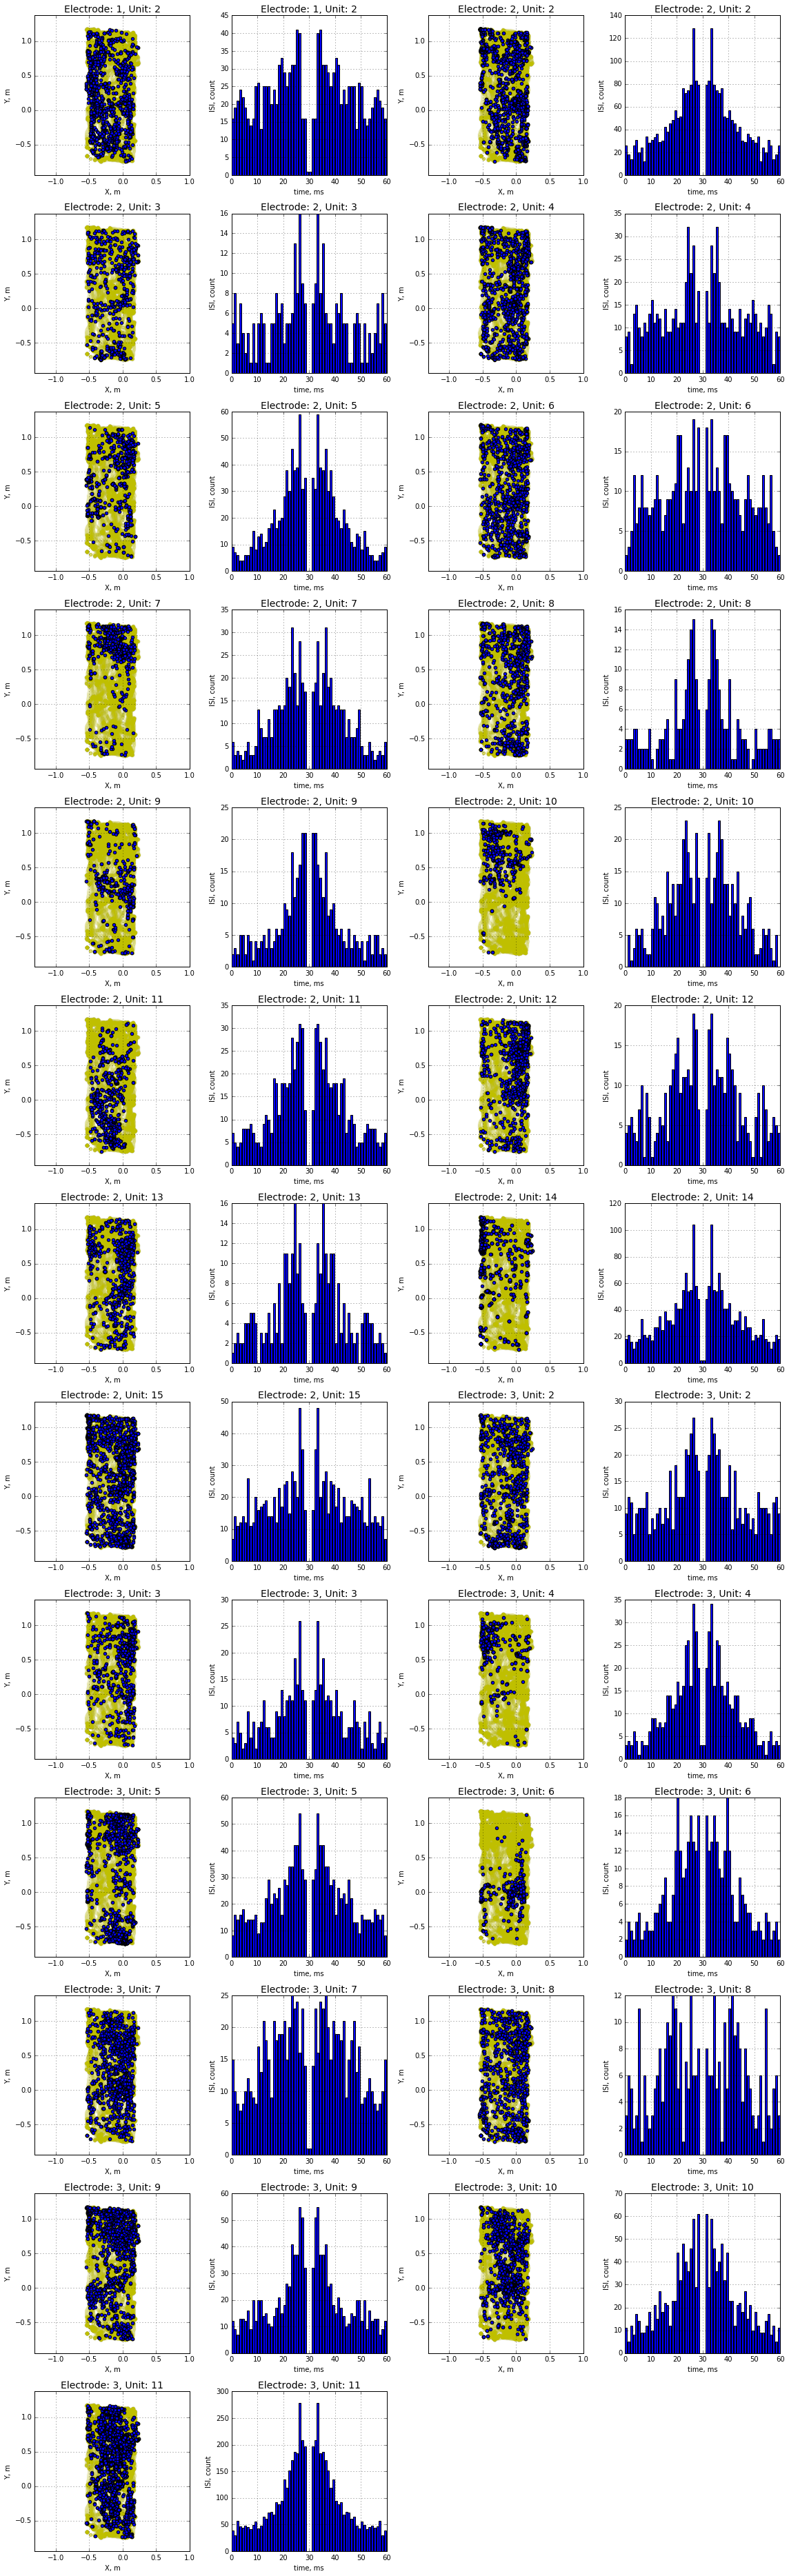

In [26]:
# drawing small plots
fig = unit_place_firing_with_autocorr(all_pos, unit_pos_dict, per_row=4)

analysis_path = os.path.join(sessionpath, 'analysis')
if not os.path.exists(analysis_path):
    os.mkdir(analysis_path)

filename = "unit_firing_maps_with_autocorr.png"
fig.savefig(os.path.join(analysis_path, filename))

# Place fields after shift 

\RTTD 6 Unit 4 completed

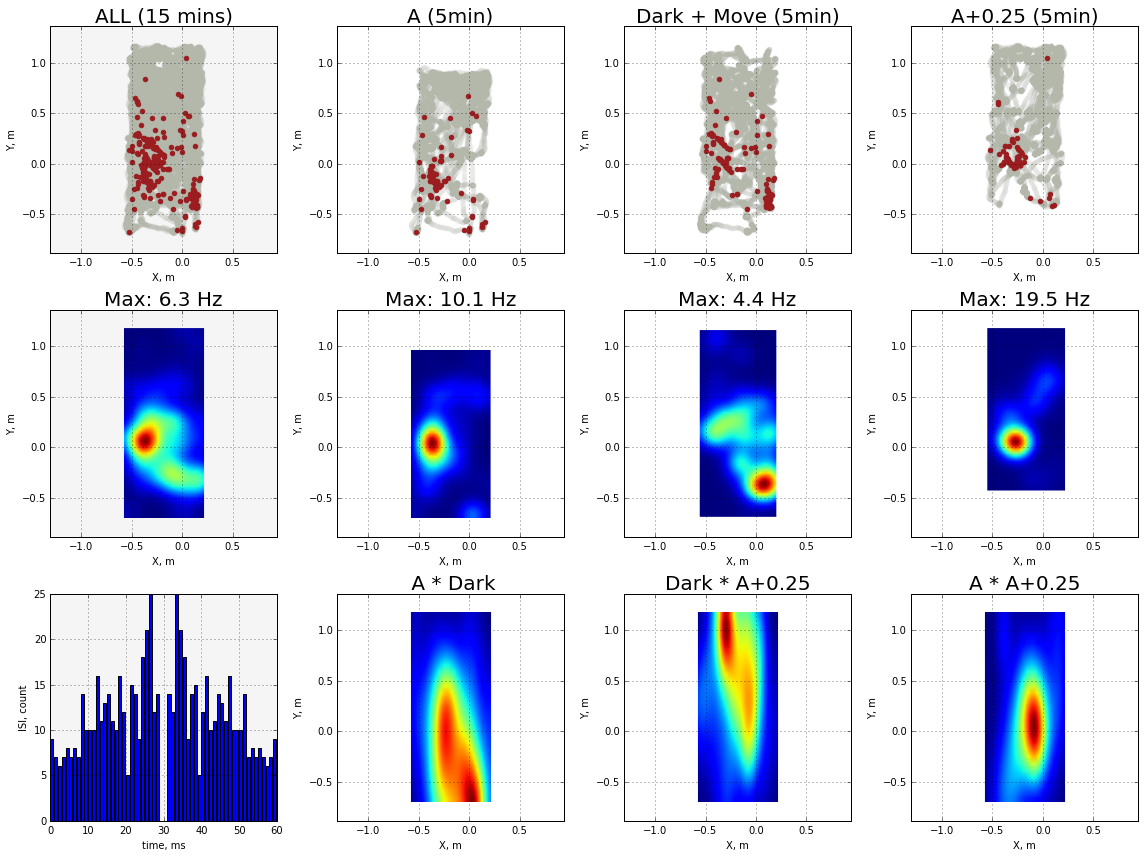

In [4]:
from analysis.plots.placecells import draw_place_field, draw_place_firing, draw_autocorrelogram
from analysis.plots.placecells import get_figure_size, get_extent
from analysis.models.analytics import place_field_2D
from matplotlib.pyplot import figure
from scipy.signal import correlate2d

sampling_rate = 50

# for ttd, units in session.tetrode_unit_map.items():
#     for unit in units:
        
ttd = 6
unit = 4

fig = figure(figsize=(4 * 4, 4 * 3))

limits = get_figure_size(session.trajectory[:, 1:3])
extent = get_extent(session.trajectory[:, 1:3])

trajectory = session.trajectory
unit_fire = session.get_positions_for_unit(ttd, unit, running_idxs)
spiket = session.get_unit_firing_at_freq(ttd, unit, sampling_rate)
pos_at_f = session.get_positions_at_freq(sampling_rate)


p1 = (session.t_start, session.t_end)                      # whole session
p2 = (session.t_start, session.t_start + 5 * 60)           # first 5 minutes
p3 = (session.t_start + 5 * 60, session.t_start + 10 * 60) # 5 minutes in dark <->
p4 = (session.t_start + 10 * 60, session.t_end)            # last 5 min +25cm shift

titles = ['ALL (15 mins)', 'A (5min)', 'Dark + Move (5min)', 'A+0.25 (5min)']
firing_fields = []

for i, period in enumerate([p1, p2, p3, p4]):
    t_start = period[0] - session.t_start
    t_end = period[1] - session.t_start

    # place spiking data
    walk = trajectory[(trajectory[:, 0] > period[0]) & (trajectory[:, 0] < period[1])][:, 1:3]
    fire = unit_fire[(unit_fire[:, 0] > period[0]) & (unit_fire[:, 0] < period[1])][:, 1:3]

    ax = fig.add_subplot(3, 4, i + 1)
    draw_place_firing(ax, walk, fire, limits=limits)
    #title = "Period %s - %s" % (int(t_start), int(t_end))
    ax.set_title(titles[i], fontsize=20)

    ax.set_aspect('equal')
    if i == 0:
        ax.set_axis_bgcolor('whitesmoke')

    # place field data
    idx_start = int((period[0] - session.t_start) * sampling_rate)
    idx_end = int((period[1] - session.t_start) * sampling_rate)

    pos = pos_at_f[idx_start:idx_end]
    st = spiket[(spiket > idx_start) & (spiket < idx_end)]
    omap, smap, fmap, s_firing_map = place_field_2D(pos, st - idx_start, sampling_rate, 0.03)
    firing_fields.append(s_firing_map)

    ax = fig.add_subplot(3, 4, i + 5)
    ext = get_extent(pos)

    draw_place_field(ax, s_firing_map, limits, ext)
    ax.set_title("Max: %2.1f Hz" % (s_firing_map.max()), fontsize=20)
    if i == 0:
        ax.set_axis_bgcolor('whitesmoke')


# autocorr    
ax = fig.add_subplot(3, 4, 9)
ax.set_axis_bgcolor('whitesmoke')
draw_autocorrelogram(ax, session.get_autocorr(ttd, unit))

# cross-corrs
cc1 = correlate2d(firing_fields[1], firing_fields[2], mode='same')
cc2 = correlate2d(firing_fields[2], firing_fields[3], mode='same')
cc3 = correlate2d(firing_fields[1], firing_fields[3], mode='same')
titles = [' A * Dark', 'Dark * A+0.25', 'A * A+0.25']

for i, cci in enumerate([cc1, cc2, cc3]):
    ax = fig.add_subplot(3, 4, i + 10)
    draw_place_field(ax, cci.T, limits=limits, extent=extent)
    ax.set_title(titles[i], fontsize=20)

fig.tight_layout()

filename = "ttd_%s_unit_%s_180.png" % (ttd, unit)
fig.savefig(os.path.join(os.path.join(sessionpath, 'analysis'), filename))

print("\RTTD %s Unit %s completed" % (ttd, unit), end="")

In [46]:
fmap = firing_fields[1]
np.where(fmap == fmap.max())

(array([9]), array([43]))

# Other approach

In [21]:
def get_filtered_pos(num_periods, lag, a_pos, u_pos, start, duration):
    t0 = a_pos[0][0]
    all_pos_f = None
    unt_pos_f = None
    
    for i in range(num_periods):  # 10 cycles in these sessions
        t_start = t0 + i * lag + start
        t_end = t_start + duration

        curr_all = a_pos[(a_pos[:, 0] > t_start) & (a_pos[:, 0] < t_end)]
        curr_unt = u_pos[(u_pos[:, 0] > t_start) & (u_pos[:, 0] < t_end)]

        if len(curr_all) > 0:
            if all_pos_f is None:
                all_pos_f = np.array(curr_all)
            else:
                all_pos_f = np.concatenate((all_pos_f, curr_all), axis=0)

        if len(curr_unt) > 0:
            if unt_pos_f is None:
                unt_pos_f = np.array(curr_unt)
            else:
                unt_pos_f = np.concatenate((unt_pos_f, curr_unt), axis=0)

    return np.array(all_pos_f), np.array(unt_pos_f)

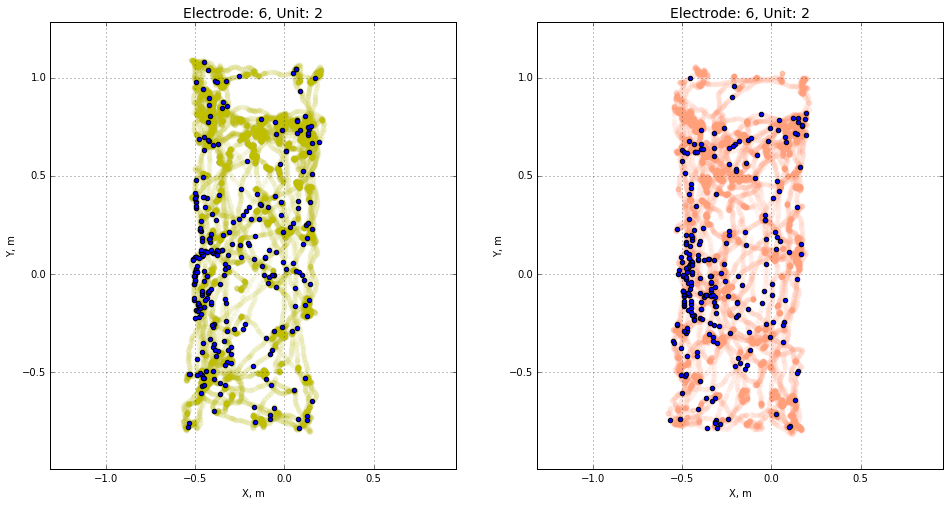

In [22]:
ttd = 6
unit = 2

all_pos = session.trajectory
unt_pos = session.get_positions_for_unit(ttd, unit, running_idxs)

# plots VShiftA where there is a shift every 10 secs
all_pos_A, unt_pos_A = get_filtered_pos(30, 20, all_pos, unt_pos, 0, 10)
all_pos_B, unt_pos_B = get_filtered_pos(30, 20, all_pos, unt_pos, 10, 10)
#all_pos_C, unt_pos_C = get_filtered_pos(1, 0, all_pos, unt_pos, 600, 300)

title = "Electrode: %s, Unit: %s" % (ttd, unit)
fig1 = double_place_field_plot(all_pos_A[:, 1:3], unt_pos_A[:, 1:3], all_pos_B[:, 1:3], unt_pos_B[:, 1:3], title)
#fig2 = double_place_field_plot(all_pos_C[:, 1:3], unt_pos_C[:, 1:3], all_pos[:, 1:3], unt_pos[:, 1:3], title)